In [1]:
import pandas as pd
import numpy as np

from keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

## 1. IMPORT DATA

In [2]:
FILE_PATH = './Data/output/'

sgd_df = pd.read_csv(FILE_PATH + 'Population_Schools_SDGs_Clean.csv', index_col=0)
sgd_df = sgd_df.dropna()
sgd_df.head()

,PSGC_BRGY,both_age_0_to_4,male_age_0_to_4,female_age_0_to_4,both_age_5_to_9,male_age_5_to_9,female_age_5_to_9,both_age_10_to_14,male_age_10_to_14,female_age_10_to_14,...,SCH_CAT_PJHS,SCH_CAT_PS,SCH_CAT_PSHS,SCH_CAT_SHS,SCH_CAT_SUC,Perc_Households_Electricity_Light,Perc_Households_Kerosene_Gass_Light,Perc_Households_Drinking_Owned_Faucet,Perc_Households_Drinking_Shared_Faucet,number_of_roads
0,PH150702001,88.0,54.0,34.0,79.0,35.0,44.0,73.0,42.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.656250,0.343750,0.050000,0.418750,0
1,PH150702002,210.0,100.0,110.0,161.0,77.0,84.0,133.0,69.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.792208,0.207792,0.051948,0.008658,1
3,PH150702005,277.0,152.0,125.0,305.0,159.0,146.0,269.0,155.0,114.0,...,0.0,0.0,0.0,0.0,0.0,0.870968,0.126728,0.099078,0.730415,5
4,PH150702006,352.0,146.0,206.0,354.0,201.0,153.0,398.0,217.0,181.0,...,0.0,0.0,0.0,0.0,0.0,0.719780,0.236264,0.001832,0.012821,4
5,PH150702007,270.0,140.0,130.0,236.0,114.0,122.0,220.0,121.0,99.0,...,0.0,0.0,0.0,0.0,0.0,0.831050,0.157534,0.287671,0.321918,14


In [54]:
enrollment_df = pd.read_csv(FILE_PATH + 'Enrollment_rate_elementary_2015.csv')
enrollment_df.head()

,province,municipality,school_name,year_level,gender,enrollment,PSGC_BRGY
0,Basilan,City Of Lamitan,Baas ES,grade 1,male,25,PH150702002
1,Basilan,City Of Lamitan,Campo Uno ES,grade 1,male,48,PH150702018
2,Basilan,City Of Lamitan,Dangkalan ES,grade 1,male,40,PH150702025
3,Basilan,City Of Lamitan,Jose Rizal ES,grade 1,male,73,PH150702068
4,Basilan,City Of Lamitan,Lamitan CES,grade 1,male,189,PH150702064


In [55]:
print('Available population data:', len(sgd_df))
print('Available enrollment data:', len(enrollment_df))
print('Enrollment data available on the following regions:', list(enrollment_df['province'].unique()))

Available population data: 1568
Available enrollment data: 6768
Enrollment data available on the following regions: ['Basilan', 'Lanao Del Sur']


In [62]:
enrollment_brgy = enrollment_df.groupby(['PSGC_BRGY'], as_index=False).sum()
enrollment_brgy

,PSGC_BRGY,enrollment
0,PH150702001,166
1,PH150702002,295
2,PH150702005,378
3,PH150702006,638
4,PH150702007,229
...,...,...
391,PH153825010,186
392,PH153829004,259
393,PH156601003,513
394,PH157004006,358


In [64]:
data_elementary = sgd_df[['PSGC_BRGY', 'both_age_7_to_12', 'male_age_7_to_12', 'female_age_7_to_12', 
                          'SCH_CAT_CES', 'SCH_CAT_ES', 'SCH_CAT_PS',
                          'Perc_Households_Electricity_Light', 'Perc_Households_Kerosene_Gass_Light',
                          'Perc_Households_Drinking_Owned_Faucet', 'Perc_Households_Drinking_Shared_Faucet',
                          'number_of_roads']]

In [66]:
dataset = data_elementary.merge(enrollment_brgy[['PSGC_BRGY', 'enrollment']], on='PSGC_BRGY', how='left')

In [68]:
dataset = dataset.dropna()
dataset.head()

,PSGC_BRGY,both_age_7_to_12,male_age_7_to_12,female_age_7_to_12,SCH_CAT_CES,SCH_CAT_ES,SCH_CAT_PS,Perc_Households_Electricity_Light,Perc_Households_Kerosene_Gass_Light,Perc_Households_Drinking_Owned_Faucet,Perc_Households_Drinking_Shared_Faucet,number_of_roads,enrollment
0,PH150702001,90.0,43.0,47.0,0.0,1.0,0.0,0.656250,0.343750,0.050000,0.418750,0,166.0
1,PH150702002,175.0,85.0,90.0,0.0,1.0,0.0,0.792208,0.207792,0.051948,0.008658,1,295.0
2,PH150702005,351.0,189.0,162.0,0.0,1.0,0.0,0.870968,0.126728,0.099078,0.730415,5,378.0
3,PH150702006,467.0,272.0,195.0,0.0,1.0,0.0,0.719780,0.236264,0.001832,0.012821,4,638.0
4,PH150702007,261.0,133.0,128.0,0.0,1.0,0.0,0.831050,0.157534,0.287671,0.321918,14,229.0


In [69]:
print('Length of data:', len(dataset))

Length of data: 396


In [70]:
dataset['ratio_enrollment_children'] = dataset['enrollment']/dataset['both_age_7_to_12']

<ipython-input-70-151a084ef04f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ratio_enrollment_children'] = dataset['enrollment']/dataset['both_age_7_to_12']


In [73]:
dataset['elem_school'] = dataset['SCH_CAT_CES'] + dataset['SCH_CAT_ES'] + dataset['SCH_CAT_PS']

<ipython-input-73-767bf4c5c5e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['elem_school'] = dataset['SCH_CAT_CES'] + dataset['SCH_CAT_ES'] + dataset['SCH_CAT_PS']


In [83]:
x = dataset['ratio_enrollment_children']
y = dataset['Perc_Households_Kerosene_Gass_Light']

print(max(x))
dataset.to_csv('sample.csv', index=False)

39.17857142857143


In [84]:
# plt.scatter(x,y)
dataset.head()

,PSGC_BRGY,both_age_7_to_12,male_age_7_to_12,female_age_7_to_12,SCH_CAT_CES,SCH_CAT_ES,SCH_CAT_PS,Perc_Households_Electricity_Light,Perc_Households_Kerosene_Gass_Light,Perc_Households_Drinking_Owned_Faucet,Perc_Households_Drinking_Shared_Faucet,number_of_roads,enrollment,ratio_enrollment_children,elem_school
0,PH150702001,90.0,43.0,47.0,0.0,1.0,0.0,0.656250,0.343750,0.050000,0.418750,0,166.0,1.844444,1.0
1,PH150702002,175.0,85.0,90.0,0.0,1.0,0.0,0.792208,0.207792,0.051948,0.008658,1,295.0,1.685714,1.0
2,PH150702005,351.0,189.0,162.0,0.0,1.0,0.0,0.870968,0.126728,0.099078,0.730415,5,378.0,1.076923,1.0
3,PH150702006,467.0,272.0,195.0,0.0,1.0,0.0,0.719780,0.236264,0.001832,0.012821,4,638.0,1.366167,1.0
4,PH150702007,261.0,133.0,128.0,0.0,1.0,0.0,0.831050,0.157534,0.287671,0.321918,14,229.0,0.877395,1.0


## 2. EXPLORE DATA

In [3]:
def subplot(x_list, y, df):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    axes = [ax1, ax2, ax3, ax4]
    for i in range(len(x_list)):
        axes[i].scatter(df[x_list[i]], y)
        axes[i].set_title(x_list[i])
    plt.tight_layout()

Plot school number vs ratio of age and population

### A. BARANGAY LEVEL

In [4]:
X_elem = ['both_age_7_to_12', 'male_age_7_to_12', 'female_age_7_to_12']
X_jhs = ['both_age_13_to_16', 'male_age_13_to_16', 'female_age_13_to_16']
X_shs = ['both_age_17_to_18', 'male_age_17_to_18', 'female_age_17_to_18']
X_col = ['both_age_19_to_22', 'male_age_19_to_22', 'female_age_19_to_22']

#### 1) ELEMENTARY SCHOOLS

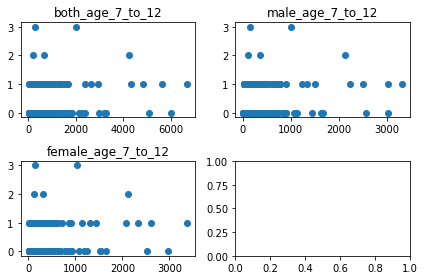

In [5]:
# Central Elementary School
subplot(X_elem, sgd_df['SCH_CAT_CES'], sgd_df)

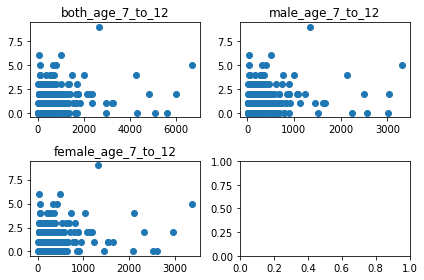

In [6]:
# Elementary School
subplot(X_elem, sgd_df['SCH_CAT_ES'], sgd_df)

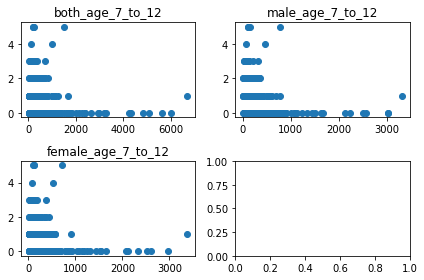

In [7]:
# Primary School
subplot(X_elem, sgd_df['SCH_CAT_PS'], sgd_df)

CES, ES, and PS are all Public Elementary Schools

In [8]:
sgd_df['PUB_ELEM_SCH'] = sgd_df['SCH_CAT_CES'] + sgd_df['SCH_CAT_ES'] + sgd_df['SCH_CAT_PS']

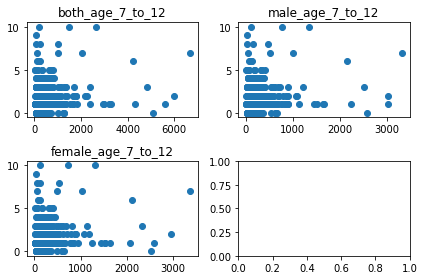

In [9]:
# All public schools
subplot(X_elem, sgd_df['PUB_ELEM_SCH'], sgd_df)

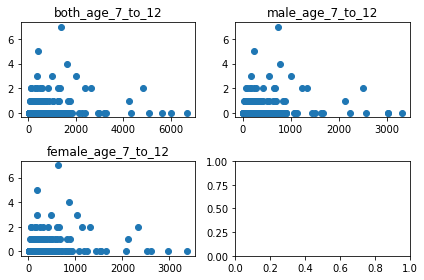

In [10]:
# Private Elementary School
subplot(X_elem, sgd_df['SCH_CAT_PES'], sgd_df)

In [11]:
sgd_df['ELEM_SCH'] = sgd_df['PUB_ELEM_SCH'] + sgd_df['SCH_CAT_PES']

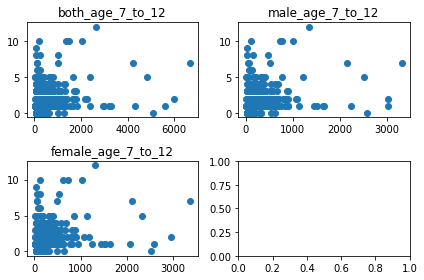

In [12]:
# All elementary schools
subplot(X_elem, sgd_df['ELEM_SCH'], sgd_df)

#### 2) JUNIOR HIGH SCHOOL

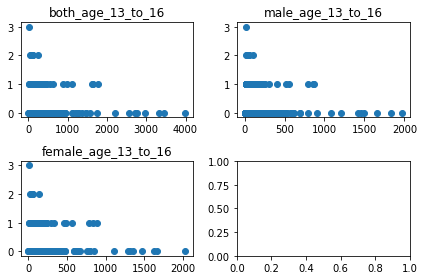

In [13]:
# Public Junior High School
subplot(X_jhs, sgd_df['SCH_CAT_JHS'], sgd_df)

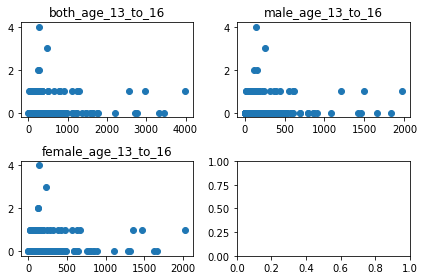

In [14]:
# Private Junior High School
subplot(X_jhs, sgd_df['SCH_CAT_PJHS'], sgd_df)

In [15]:
sgd_df['JHS_SCH'] = sgd_df['SCH_CAT_JHS'] + sgd_df['SCH_CAT_PJHS']

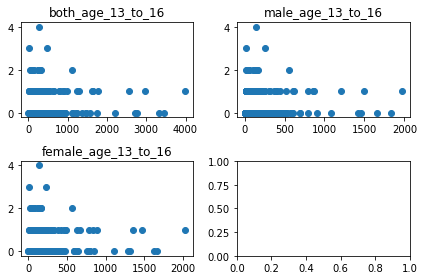

In [16]:
# All JHS
subplot(X_jhs, sgd_df['JHS_SCH'], sgd_df)

#### 3) Senior High School

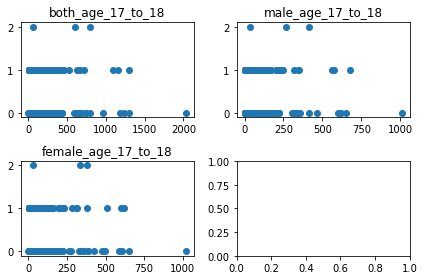

In [17]:
# Public Senior High School
subplot(X_shs, sgd_df['SCH_CAT_SHS'], sgd_df)

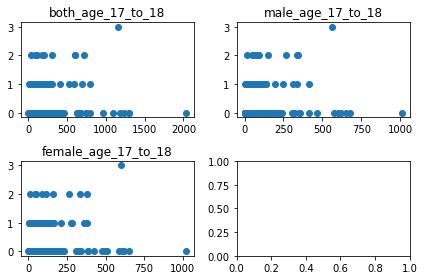

In [18]:
# Private Senior High School
subplot(X_shs, sgd_df['SCH_CAT_PSHS'], sgd_df)

In [19]:
sgd_df['SHS_SCH'] = sgd_df['SCH_CAT_SHS'] + sgd_df['SCH_CAT_PSHS']

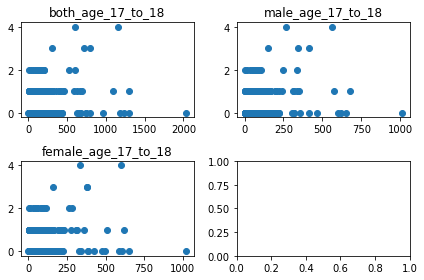

In [20]:
# All SHS
subplot(X_shs, sgd_df['SHS_SCH'], sgd_df)

#### 4) SUC

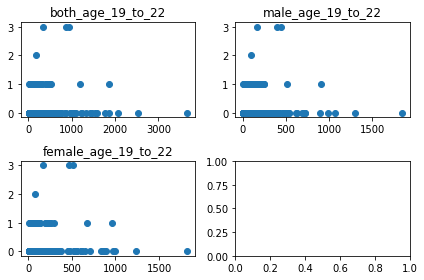

In [21]:
# SUC
subplot(X_col, sgd_df['SCH_TYPE_SUC'], sgd_df)

### B) MUNICIPAL LEVEL

In [22]:
df_muni = pd.read_excel('./Data/tabular/Number of schools per brgy.xlsx')
df_muni.head()

,PROV,PSGC_PROV,CITY/MUNI,PSGC_CITY/MUNI,BRGY,PSGC_BRGY,Number of School
0,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Arco,PH150702001,1
1,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Ba-as,PH150702002,1
2,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Balagtasan,PH150702005,1
3,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Balas,PH150702006,1
4,BASILAN,PH150700000,CITY OF LAMITAN (Capital),PH150702000,Balobo,PH150702007,1


In [23]:
df_muni = df_muni.merge(sgd_df, on=['PSGC_BRGY'])

In [24]:
df_muni = df_muni.groupby(['PSGC_CITY/MUNI']).agg('sum')

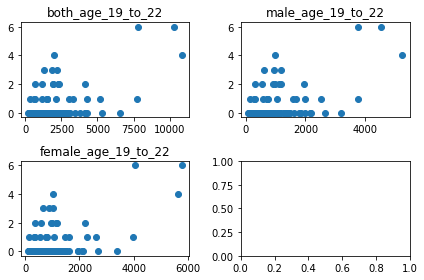

In [25]:
#SUC
subplot(X_col, df_muni['SCH_TYPE_SUC'], df_muni)

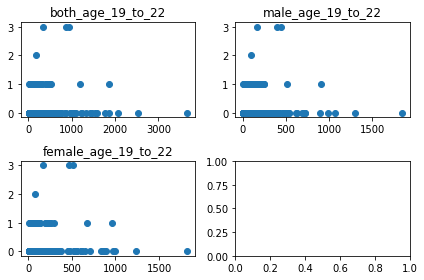

In [26]:
subplot(X_col, sgd_df['SCH_TYPE_SUC'], sgd_df)

In [27]:
dataset = sgd_df[['PUB_ELEM_SCH', 'both_age_7_to_12', 'number_of_roads']]

### C) ROAD VS NUMBER OF SCHOOLS

## 3. Preprocess data

### Train test split

In [28]:
training_data, testing_data = train_test_split(dataset, test_size=0.2, random_state=42)

In [29]:
X_train = training_data.drop(['PUB_ELEM_SCH'], axis=1)
y_train = training_data['PUB_ELEM_SCH']

X_test = testing_data.drop(['PUB_ELEM_SCH'], axis=1)
y_test = testing_data['PUB_ELEM_SCH']

### Normalization

In [30]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X_train))

### Feature Selection

In [31]:
# min(df['elem_both_age'])

### Modelling

In [32]:
model = Sequential()
model.add(normalizer)
model.add(Dense(20, activation='tanh', input_dim=5, kernel_initializer='uniform'))
model.add(Dense(1, activation='linear', kernel_initializer='uniform'))

In [33]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [34]:
EPOCHS = 100
BATCH_SIZE = 10
history = model.fit(X_train, 
                    y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2)

Epoch 1/100
101/101 [==============================] - 5s 32ms/step - loss: 2.1724 - mse: 2.1724 - val_loss: 2.2729 - val_mse: 2.2729
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 1.3908 - mse: 1.3908 - val_loss: 1.2937 - val_mse: 1.2937
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 0.6978 - mse: 0.6978 - val_loss: 1.2171 - val_mse: 1.2171
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 0.6958 - mse: 0.6958 - val_loss: 1.2029 - val_mse: 1.2029
Epoch 5/100
101/101 [==============================] - 0s 3ms/step - loss: 0.8748 - mse: 0.8748 - val_loss: 1.2133 - val_mse: 1.2133
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 0.7808 - mse: 0.7808 - val_loss: 1.2149 - val_mse: 1.2149
Epoch 7/100
101/101 [==============================] - 0s 2ms/step - loss: 0.6272 - mse: 0.6272 - val_loss: 1.2092 - val_mse: 1.2092
Epoch 8/100
101/101 [==============================] - 0s 2ms/step -

101/101 [==============================] - 0s 4ms/step - loss: 0.6803 - mse: 0.6803 - val_loss: 1.1831 - val_mse: 1.1831
Epoch 63/100
101/101 [==============================] - 0s 4ms/step - loss: 0.7569 - mse: 0.7569 - val_loss: 1.1864 - val_mse: 1.1864
Epoch 64/100
101/101 [==============================] - 0s 2ms/step - loss: 0.6202 - mse: 0.6202 - val_loss: 1.1810 - val_mse: 1.1810
Epoch 65/100
101/101 [==============================] - 0s 2ms/step - loss: 0.7983 - mse: 0.7983 - val_loss: 1.1880 - val_mse: 1.1880
Epoch 66/100
101/101 [==============================] - 0s 2ms/step - loss: 0.7535 - mse: 0.7535 - val_loss: 1.1933 - val_mse: 1.1933
Epoch 67/100
101/101 [==============================] - 0s 2ms/step - loss: 0.7649 - mse: 0.7649 - val_loss: 1.1927 - val_mse: 1.1927
Epoch 68/100
101/101 [==============================] - 0s 2ms/step - loss: 0.6907 - mse: 0.6907 - val_loss: 1.1925 - val_mse: 1.1925
Epoch 69/100
101/101 [==============================] - 0s 2ms/step - loss:

## 4. Model evaluation

In [35]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,0.725118,0.725118,1.192057,1.192057,95
96,0.724712,0.724712,1.195630,1.195630,96
97,0.724572,0.724572,1.204307,1.204307,97
98,0.725121,0.725121,1.199611,1.199611,98
99,0.724460,0.724460,1.189583,1.189583,99


In [36]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

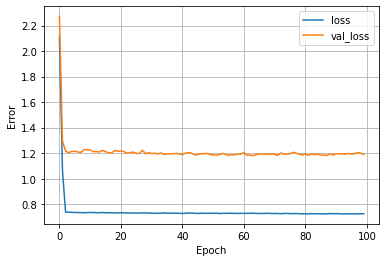

In [37]:
plot_loss(history)

##### TO DO:
1. Feature selection
2. Model evaluation (variance, loss)
3. Choose

# CLUSTERING

## Method 1: KMeans

In [38]:
kmeans_data = sgd_df[['ELEM_SCH', 'both_age_7_to_12', 'Perc_Households_Electricity_Light', 
                      'Perc_Households_Kerosene_Gass_Light', 'Perc_Households_Drinking_Owned_Faucet',
                     'Perc_Households_Drinking_Shared_Faucet', 'number_of_roads']]
kmeans_data

,ELEM_SCH,both_age_7_to_12,Perc_Households_Electricity_Light,Perc_Households_Kerosene_Gass_Light,Perc_Households_Drinking_Owned_Faucet,Perc_Households_Drinking_Shared_Faucet,number_of_roads
0,1.0,90.0,0.656250,0.343750,0.050000,0.418750,0
1,1.0,175.0,0.792208,0.207792,0.051948,0.008658,1
3,1.0,351.0,0.870968,0.126728,0.099078,0.730415,5
4,1.0,467.0,0.719780,0.236264,0.001832,0.012821,4
5,1.0,261.0,0.831050,0.157534,0.287671,0.321918,14
...,...,...,...,...,...,...,...
2476,1.0,200.0,0.951662,0.048338,0.003021,0.012085,2
2477,1.0,451.0,0.970822,0.015915,0.000000,0.323607,1
2478,1.0,385.0,0.877119,0.097458,0.002119,0.830508,1
2479,1.0,232.0,0.930693,0.023102,0.323432,0.000000,1


### Standardization

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(kmeans_data)

### PCA

In [41]:
from sklearn.decomposition import PCA

In [42]:
pca = PCA(n_components=7)
principal_components = pca.fit_transform(scaled_features)

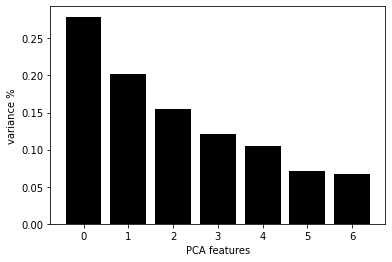

In [43]:
# Plot explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

Text(0, 0.5, 'PCA 2')

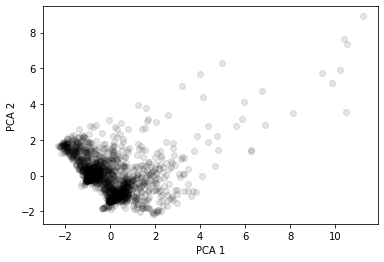

In [44]:
PCA_components = pd.DataFrame(principal_components)

plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

### Clustering

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [46]:
sse = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

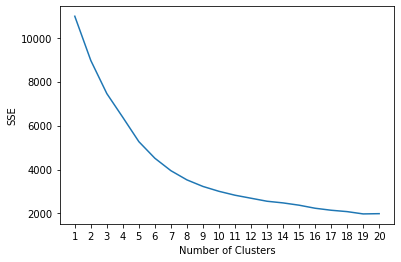

In [47]:
plt.plot(range(1,21), sse)
plt.xticks(range(1,21))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [48]:
clusters = 10

In [49]:
kmeans = KMeans(n_clusters=clusters)
predicted = kmeans.fit_predict(scaled_features)

In [50]:
kmeans_data['clusters'] = predicted

<ipython-input-50-8e73074ba877>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_data['clusters'] = predicted


In [51]:
kmeans_data['Brgy'] = sgd_df['PSGC_BRGY']

<ipython-input-51-db6d6191f186>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_data['Brgy'] = sgd_df['PSGC_BRGY']


In [52]:
kmeans_data.to_csv('./Data/output/cluster_output.csv', index=False)